<a href="https://colab.research.google.com/github/LineIntegralx/CalligraNet/blob/main/EDA%20%26%20Preprocessing/HICMA_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from pathlib import Path
import os
import shutil
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import albumentations as A


In [3]:
PREPROC_BASE = Path("/content/drive/MyDrive/EECE693_Project/Preprocessed_HICMA")
AUG_BASE     = Path("/content/drive/MyDrive/EECE693_Project/Augmented_HICMA")

# Preprocessed splits
PRE_TRAIN_IMG = PREPROC_BASE / "train" / "images"
PRE_VAL_IMG   = PREPROC_BASE / "val"   / "images"
PRE_TEST_IMG  = PREPROC_BASE / "test"  / "images"

PRE_TRAIN_CSV = PREPROC_BASE / "train_labels.csv"
PRE_VAL_CSV   = PREPROC_BASE / "val_labels.csv"
PRE_TEST_CSV  = PREPROC_BASE / "test_labels.csv"

# Augmented splits
AUG_TRAIN_IMG = AUG_BASE / "train" / "images"
AUG_VAL_IMG   = AUG_BASE / "val"   / "images"
AUG_TEST_IMG  = AUG_BASE / "test"  / "images"

for d in [AUG_TRAIN_IMG, AUG_VAL_IMG, AUG_TEST_IMG]:
    d.mkdir(parents=True, exist_ok=True)

AUG_BASE


PosixPath('/content/drive/MyDrive/EECE693_Project/Augmented_HICMA')

In [4]:
df_train = pd.read_csv(PRE_TRAIN_CSV)
df_val   = pd.read_csv(PRE_VAL_CSV)
df_test  = pd.read_csv(PRE_TEST_CSV)

for df in [df_train, df_val, df_test]:
    df["img_name"] = df["img_name"].astype(str).str.strip()

print("Train:", len(df_train))
print("Val  :", len(df_val))
print("Test :", len(df_test))
print(df_train["class"].value_counts())


Train: 4020
Val  : 502
Test : 503
class
Naskh       2988
Thuluth      808
Diwani       190
Kufic         21
Muhaquaq      13
Name: count, dtype: int64


In [10]:
import random
import albumentations as A
import cv2

BG = 255  # white background for padding / transforms


def binarize_and_maybe_invert(image, invert_prob=0.5):
    """
    image: grayscale uint8
    - Otsu binarization
    - maybe invert FG/BG
    """
    if image.ndim == 3:  # just in case
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, th = cv2.threshold(image, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if random.random() < invert_prob:
        th = 255 - th
    return th


def make_safe_geom(rotate_limit=4, shrink=0.10, translate=0.02, p=0.8):
    """
    Geometry that NEVER crops text:
    - only zoom OUT (scale <= 1)
    - small rotations
    - small translations
    - fit_output=True keeps everything inside frame
    """
    return [
        A.Affine(
            scale=(1.0 - shrink, 1.0 - shrink),    # [1-shrink, 1-shrink]
            rotate=(-rotate_limit, rotate_limit),  # deg
            translate_percent=(-translate, translate),
            fit_output=True,
            cval=BG,
            mode=cv2.BORDER_CONSTANT,
            p=p,
        )
    ]


def photometric_light():
    return [
        A.RandomBrightnessContrast(
            brightness_limit=0.10,
            contrast_limit=0.10,
            p=0.6,
        ),
        A.GaussNoise(
            var_limit=(5.0, 20.0),
            p=0.4,
        ),
        A.MotionBlur(
            blur_limit=3,
            p=0.2,
        ),
    ]


def photometric_medium():
    return [
        A.RandomBrightnessContrast(
            brightness_limit=0.15,
            contrast_limit=0.15,
            p=0.7,
        ),
        A.GaussNoise(
            var_limit=(5.0, 30.0),
            p=0.5,
        ),
        A.MotionBlur(
            blur_limit=5,
            p=0.3,
        ),
    ]


def photometric_strong():
    return [
        A.RandomBrightnessContrast(
            brightness_limit=0.20,
            contrast_limit=0.20,
            p=0.7,
        ),
        A.GaussNoise(
            var_limit=(10.0, 40.0),
            p=0.6,
        ),
        A.MotionBlur(
            blur_limit=5,
            p=0.3,
        ),
        # occasional binarize + maybe invert
        A.Lambda(
            image=lambda img, **kw: binarize_and_maybe_invert(img, invert_prob=0.5),
            p=0.3,
        ),
    ]


# ---------- FINAL AUG PIPELINES (SAFE) ----------

# Naskh (big class) – gentlest
aug_light = A.Compose(
    make_safe_geom(rotate_limit=3, shrink=0.06, translate=0.015, p=0.7)
    + photometric_light()
)

# Thuluth, Diwani – medium
aug_medium = A.Compose(
    make_safe_geom(rotate_limit=4, shrink=0.10, translate=0.02, p=0.8)
    + photometric_medium()
)

# Kufic, Muhaqqaq – stronger but still safe
aug_strong = A.Compose(
    make_safe_geom(rotate_limit=6, shrink=0.13, translate=0.025, p=0.9)
    + photometric_strong()
)


/tmp/ipython-input-1275321175.py:33: UserWarning: Argument(s) 'cval, mode' are not valid for transform Affine
  A.Affine(
/tmp/ipython-input-1275321175.py:52: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(
/tmp/ipython-input-1275321175.py:70: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(
/tmp/ipython-input-1275321175.py:88: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(
/tmp/ipython-input-1275321175.py:97: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(


In [11]:
def get_augment_for_style(style: str):
    """
    Map each script style to an augmentation pipeline.
    """
    if style == "Naskh":
        return aug_light
    elif style in ["Thuluth", "Diwani"]:
        return aug_medium
    else:  # Kufic, Muhaquaq, anything rare
        return aug_strong


In [12]:
import matplotlib.pyplot as plt
from pathlib import Path

def show_aug_examples_for_style(style, df, images_dir, aug, n=4):
    subset = df[df["class"] == style]
    if len(subset) == 0:
        print(f"No samples for style {style}")
        return

    sample_rows = subset.sample(min(n, len(subset)), random_state=42)

    plt.figure(figsize=(4 * n, 6))
    for i, (_, row) in enumerate(sample_rows.iterrows(), start=1):
        img_path = Path(images_dir) / row["img_name"]
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

        aug_img = aug(image=img)["image"]

        # original
        plt.subplot(2, n, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"{style} - orig", fontsize=9)

        # augmented
        plt.subplot(2, n, i + n)
        plt.imshow(aug_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{style} - aug", fontsize=9)

    plt.tight_layout()
    plt.show()


Style: Naskh


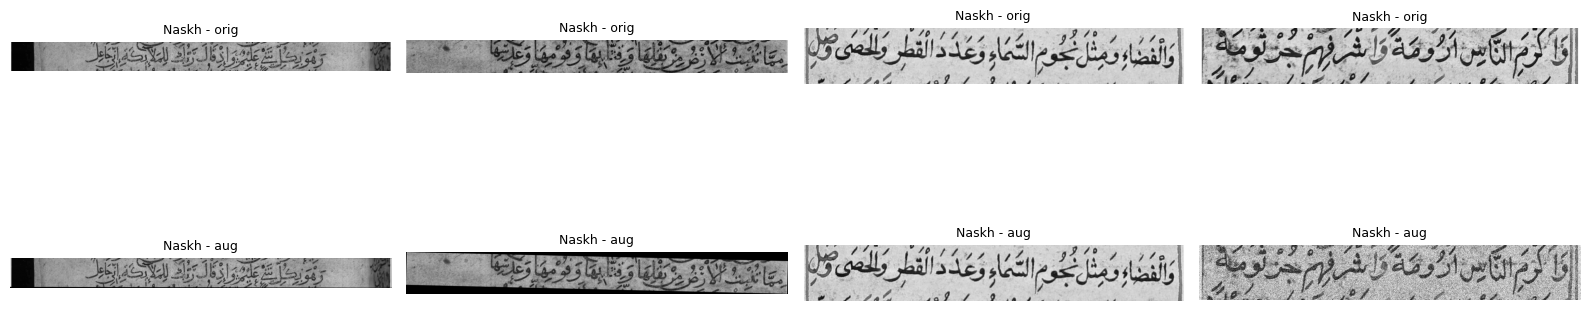

Style: Thuluth


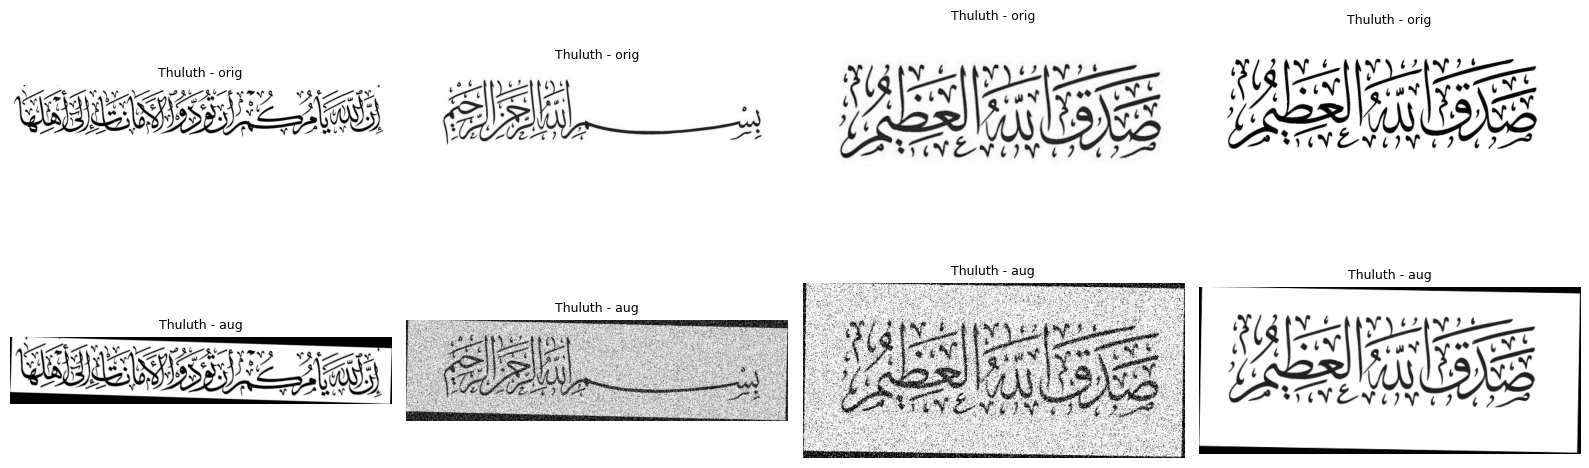

Style: Diwani


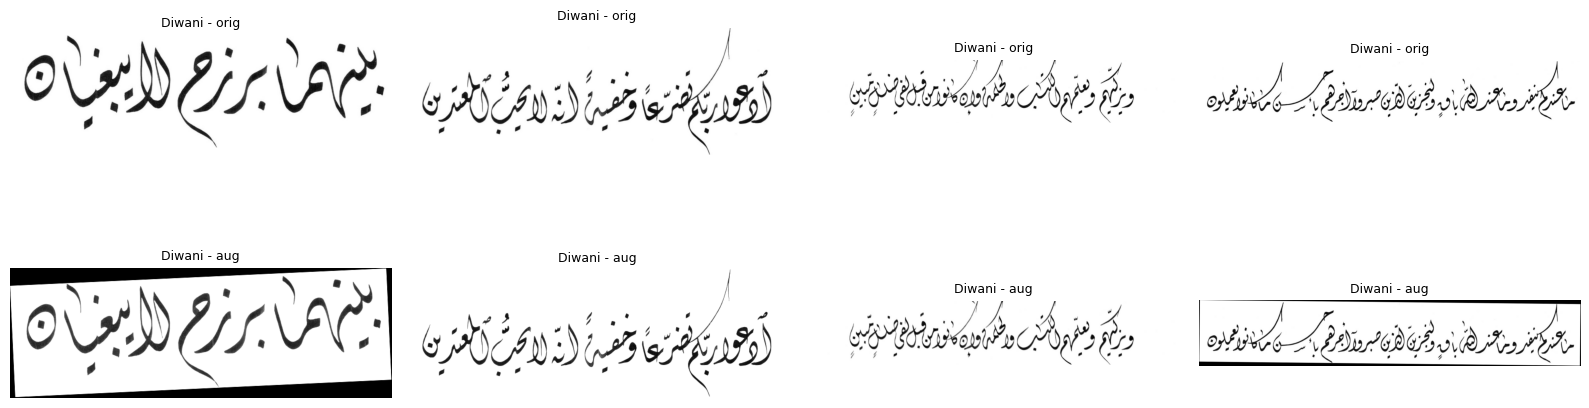

Style: Muhaquaq


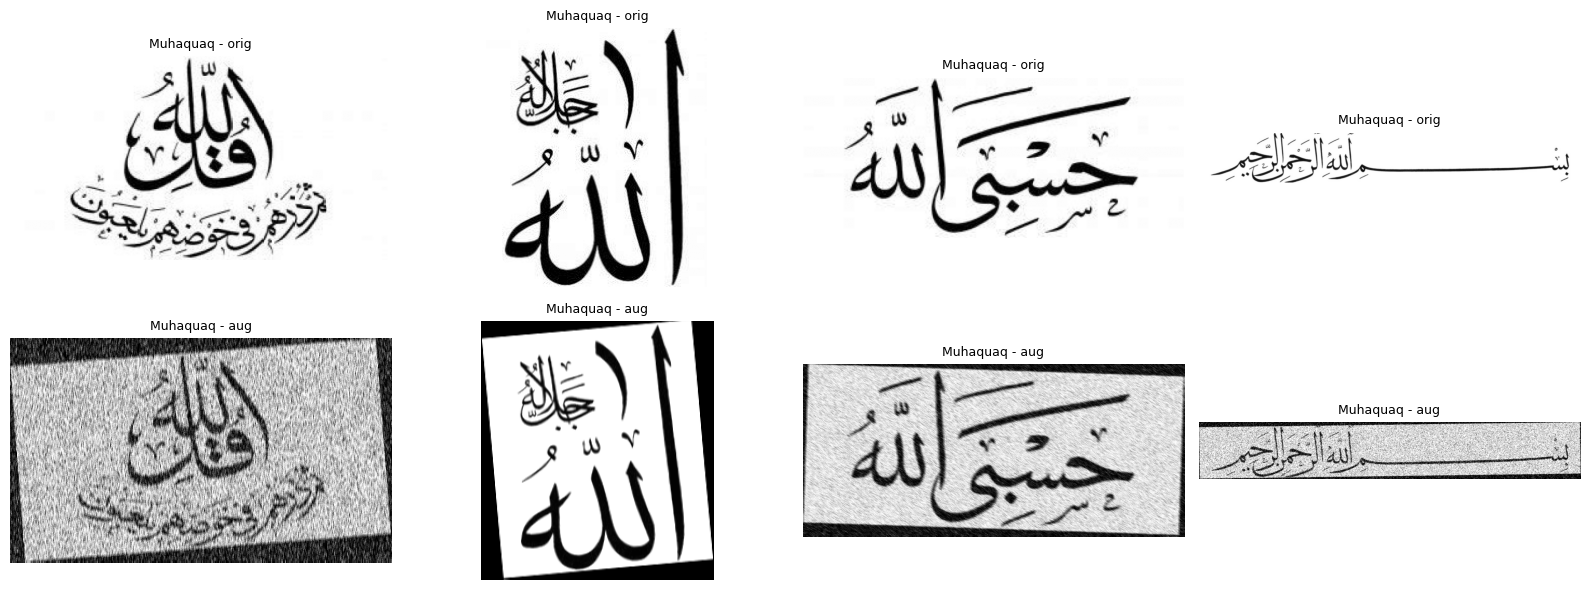

Style: Kufic


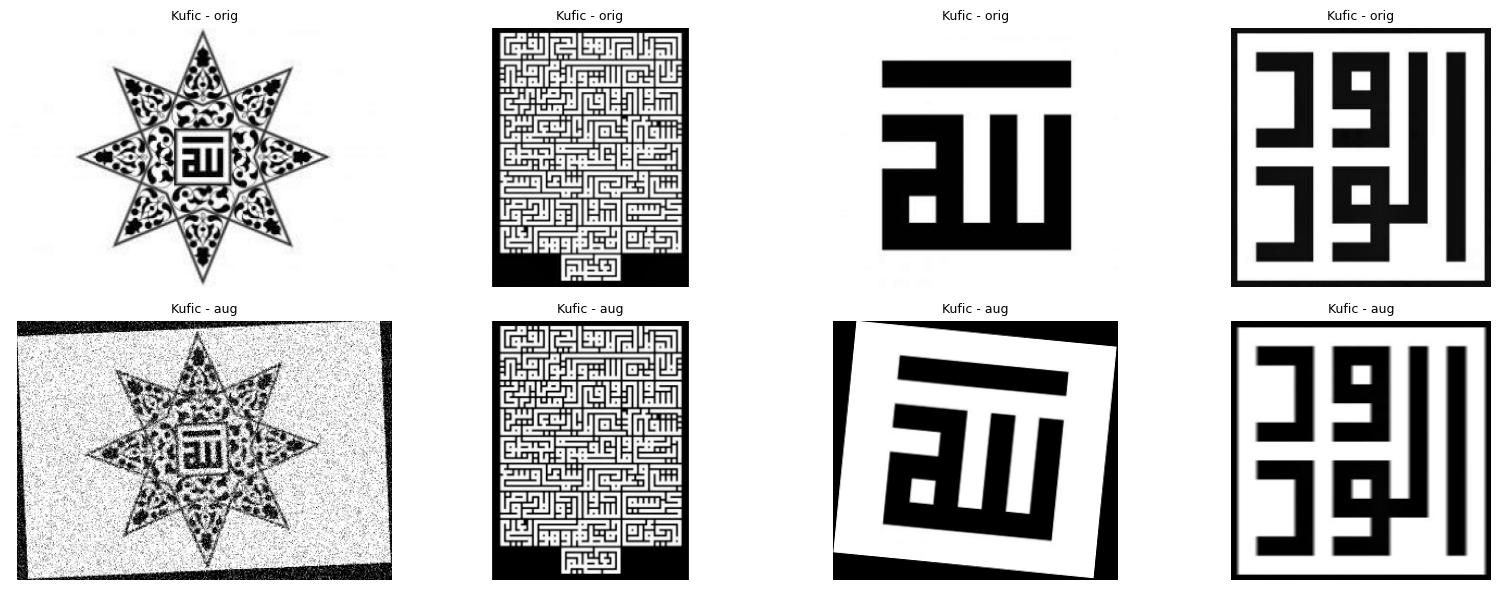

In [13]:
for style in df_train["class"].unique():
    aug = get_augment_for_style(style)
    print(f"Style: {style}")
    show_aug_examples_for_style(style, df_train, PRE_TRAIN_IMG, aug, n=4)


In [14]:
# copy original train images to augmented train folder
for _, row in tqdm(df_train.iterrows(), total=len(df_train), desc="Copying original train images"):
    src = PRE_TRAIN_IMG / row["img_name"]
    dst = AUG_TRAIN_IMG / row["img_name"]
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)


Copying original train images: 100%|██████████| 4020/4020 [10:20<00:00,  6.48it/s]


In [15]:
df_train_aug = df_train.copy()  # will also hold augmented rows


In [16]:
TARGET_PER_STYLE = 4000

style_counts = df_train["class"].value_counts()
style_counts


,count
class,
Naskh,2988
Thuluth,808
Diwani,190
Kufic,21
Muhaquaq,13


In [17]:
generated = 0
aug_rows = []

for style, original_count in style_counts.items():
    target = TARGET_PER_STYLE
    if original_count >= target:
        print(f"{style}: already >= target ({original_count}), no need to augment.")
        continue

    needed = target - original_count
    print(f"{style}: {original_count} → need {needed} augmented samples.")

    df_style = df_train[df_train["class"] == style].reset_index(drop=True)
    aug_pipeline = get_augment_for_style(style)

    i = 0
    while i < needed:
        # sample a source row
        row = df_style.sample(1, random_state=None).iloc[0]
        img_name = row["img_name"]
        src_path = PRE_TRAIN_IMG / img_name

        img = cv2.imread(str(src_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # apply augmentation
        aug_img = aug_pipeline(image=img)["image"]

        # create new unique filename
        stem = Path(img_name).stem
        new_name = f"{stem}_aug_{i}.png"
        dst_path = AUG_TRAIN_IMG / new_name

        # avoid collision (just in case)
        counter = 1
        while dst_path.exists():
            new_name = f"{stem}_aug_{i}_{counter}.png"
            dst_path = AUG_TRAIN_IMG / new_name
            counter += 1

        cv2.imwrite(str(dst_path), aug_img)

        # record new row
        new_row = row.copy()
        new_row["img_name"] = new_name
        h, w = aug_img.shape[:2]
        if "height" in new_row.index:
            new_row["height"] = h
        if "width" in new_row.index:
            new_row["width"] = w
        aug_rows.append(new_row)

        i += 1
        generated += 1

print("Total augmented samples created:", generated)


Naskh: 2988 → need 1012 augmented samples.
Thuluth: 808 → need 3192 augmented samples.
Diwani: 190 → need 3810 augmented samples.
Kufic: 21 → need 3979 augmented samples.
Muhaquaq: 13 → need 3987 augmented samples.
Total augmented samples created: 15980


In [18]:
df_aug_extra = pd.DataFrame(aug_rows)
df_train_final = pd.concat([df_train_aug, df_aug_extra], ignore_index=True)

print("Original train size:", len(df_train))
print("Augmented train size:", len(df_train_final))
print(df_train_final["class"].value_counts())


Original train size: 4020
Augmented train size: 20000
class
Naskh       4000
Thuluth     4000
Diwani      4000
Muhaquaq    4000
Kufic       4000
Name: count, dtype: int64


In [19]:
AUG_TRAIN_CSV = AUG_BASE / "train_labels.csv"
df_train_final.to_csv(AUG_TRAIN_CSV, index=False)
AUG_TRAIN_CSV


PosixPath('/content/drive/MyDrive/EECE693_Project/Augmented_HICMA/train_labels.csv')

In [20]:
# copy val images
for _, row in tqdm(df_val.iterrows(), total=len(df_val), desc="Copying val images"):
    src = PRE_VAL_IMG / row["img_name"]
    dst = AUG_VAL_IMG / row["img_name"]
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)

# copy test images
for _, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Copying test images"):
    src = PRE_TEST_IMG / row["img_name"]
    dst = AUG_TEST_IMG / row["img_name"]
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)


Copying test images: 100%|██████████| 503/503 [01:19<00:00,  6.35it/s]


In [21]:
AUG_VAL_CSV  = AUG_BASE / "val_labels.csv"
AUG_TEST_CSV = AUG_BASE / "test_labels.csv"

df_val.to_csv(AUG_VAL_CSV, index=False)
df_test.to_csv(AUG_TEST_CSV, index=False)

AUG_VAL_CSV, AUG_TEST_CSV


(PosixPath('/content/drive/MyDrive/EECE693_Project/Augmented_HICMA/val_labels.csv'),
 PosixPath('/content/drive/MyDrive/EECE693_Project/Augmented_HICMA/test_labels.csv'))

In [22]:
df_train_final = pd.read_csv(AUG_TRAIN_CSV)
df_val_final   = pd.read_csv(AUG_VAL_CSV)
df_test_final  = pd.read_csv(AUG_TEST_CSV)

print("Train counts:\n", df_train_final["class"].value_counts(), "\n")
print("Val counts:\n",   df_val_final["class"].value_counts(), "\n")
print("Test counts:\n",  df_test_final["class"].value_counts())


Train counts:
 class
Naskh       4000
Thuluth     4000
Diwani      4000
Muhaquaq    4000
Kufic       4000
Name: count, dtype: int64 

Val counts:
 class
Naskh       373
Thuluth     101
Diwani       23
Kufic         3
Muhaquaq      2
Name: count, dtype: int64 

Test counts:
 class
Naskh       374
Thuluth     101
Diwani       24
Muhaquaq      2
Kufic         2
Name: count, dtype: int64


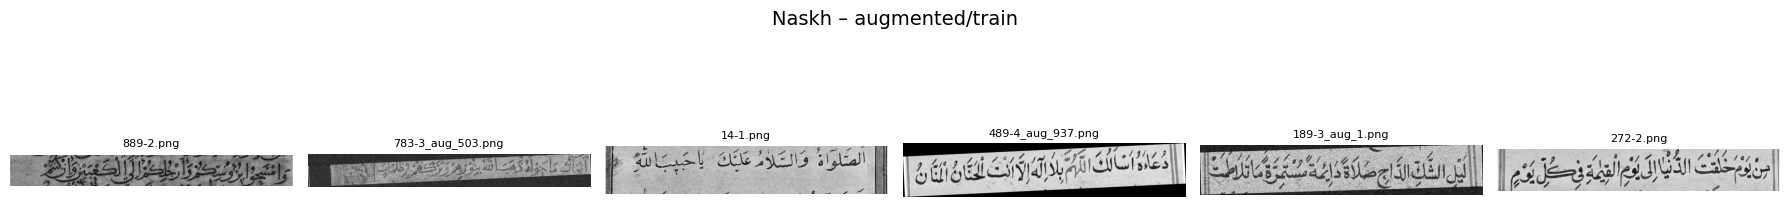

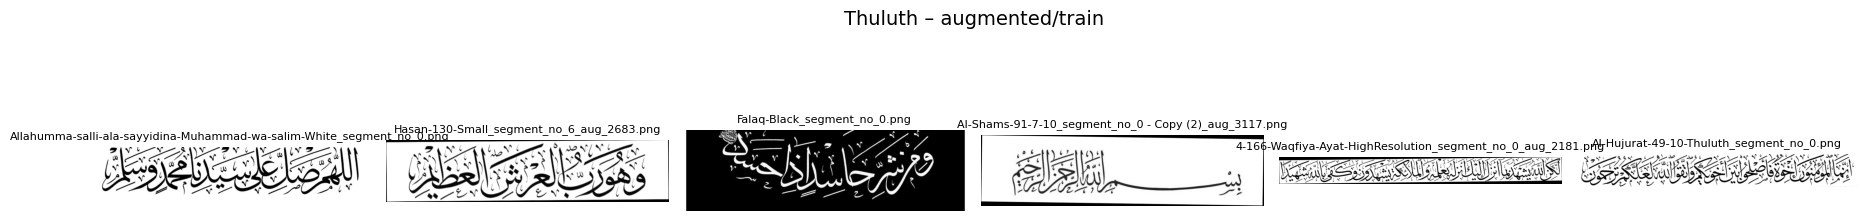

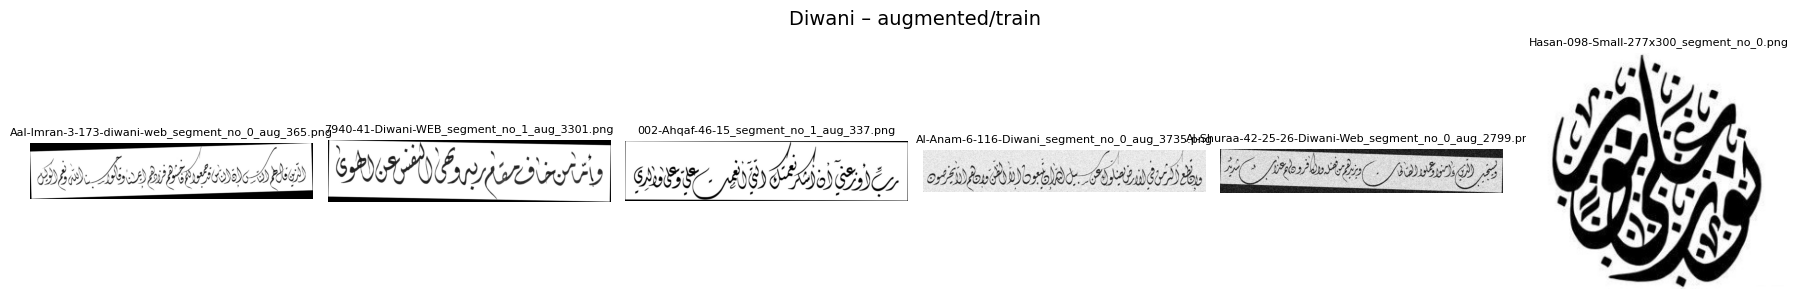

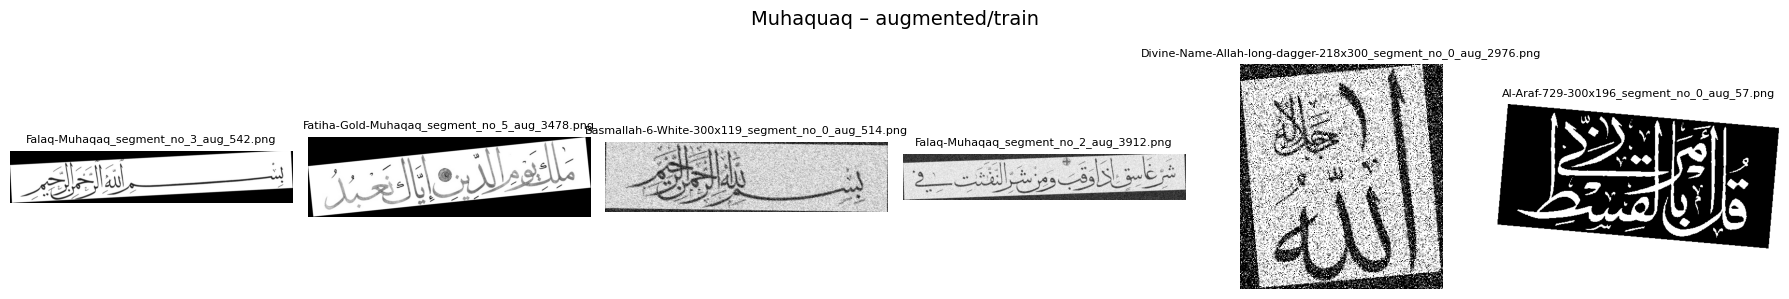

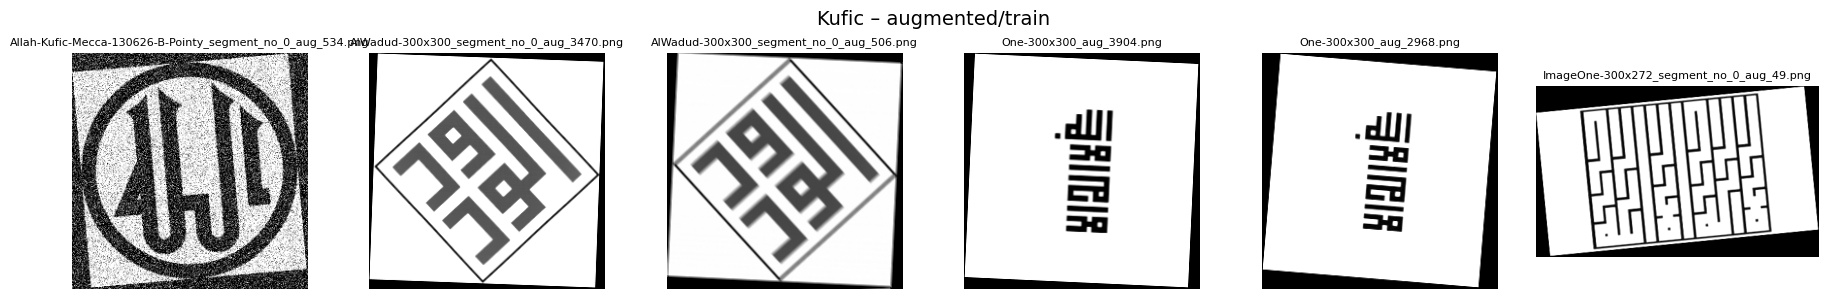

In [23]:
def show_augmented_samples(style, df, img_dir, n=6):
    subset = df[df["class"] == style]
    sample = subset.sample(min(n, len(subset)), random_state=42)

    cols = n
    plt.figure(figsize=(3*cols, 3))
    for i, (_, row) in enumerate(sample.iterrows(), start=1):
        img = cv2.imread(str(img_dir / row["img_name"]), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, cols, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(row["img_name"], fontsize=8)
    plt.suptitle(f"{style} – augmented/train", fontsize=14)
    plt.tight_layout()
    plt.show()

for style in df_train_final["class"].unique():
    show_augmented_samples(style, df_train_final, AUG_TRAIN_IMG, n=6)
